In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from os import listdir
from scipy.stats import ks_2samp, f_oneway
import scipy.cluster.hierarchy as sch
from matplotlib.ticker import FormatStrFormatter
from scipy.spatial.distance import squareform
from copy import deepcopy
from numpy import *

rcParams = {'font.size': 20, 
            'font.weight': 'normal', 
            'font.family': 'sans-serif',
            'axes.unicode_minus':False, 
            'axes.labelweight':'normal', 
            'xtick.labelsize' : 16,
            'ytick.labelsize' : 16,
            'axes.labelsize': 20,
            'axes.spines.right' : False,
            'axes.spines.top' : False}

plt.rcParams.update(rcParams)

whiskerprops = dict(color='black',linewidth=1.5)
capprops = dict(color='black', linewidth=0.5)
medianprops = dict(linewidth=1.5, linestyle='-', color='black')

plots_dir = '/Users/harihara/Research-Activities/Plots/Hot_Spring_Plots/Synechococcus-Paper-New-Plots/'

In [4]:
genomes = ['OSA','OSB','Synechococcus','Chloroflexus_MS_G', 'Chloracidobacterium_thermophilum_B',
           'Roseiflexus','Aerophilum']
genome_names = ['Synechococcus sp. JA-3-3Ab (OS-A)', 'Synechococcus sp. JA-2-3B\'a (2-13) (OS-B\')', 
                'Synechococcus', 'Chloroflexus MS G', 'Chloracidobacterium thermophilum B', 
                'Roseiflexus', 'Ca.T Aerophilum' ]
data_dir = '/Users/harihara/Research-Activities/Data/Hot-Spring/Summary/'
Summary = {}
for g in genomes:
    Summary[g] = {}
    for f in ['Orphaned_Reads.Summary.pkl','Reassembly.Summary.pkl',
              'Respresentative_Abundances.Summary.pkl', 'SAG.Summary.pkl']:
        try: Summary[g][f] = pkl.load(open(data_dir+g+'/'+f, 'rb'))
        except FileNotFoundError: print(g, f)
        

OSA Respresentative_Abundances.Summary.pkl
OSA SAG.Summary.pkl
OSB Respresentative_Abundances.Summary.pkl
OSB SAG.Summary.pkl
Synechococcus Orphaned_Reads.Summary.pkl
Synechococcus Reassembly.Summary.pkl
Chloroflexus_MS_G SAG.Summary.pkl
Chloracidobacterium_thermophilum_B SAG.Summary.pkl
Roseiflexus SAG.Summary.pkl
Aerophilum SAG.Summary.pkl


In [5]:
hotsprings = Summary['OSA']['Reassembly.Summary.pkl']['Summary']['Sample'].tolist()
df_Metadata = pd.read_excel('/Users/harihara/Research-Activities/Data/Hot-Spring/hotspring_metadata.xlsx')
df_Metadata = df_Metadata.sort_values(by = ['Spring','Year','Avg_temperature'])
df_Metadata['Spring'] = df_Metadata['Spring'].str.replace("Spring","")
df_Metadata = df_Metadata[df_Metadata['Sample_name'].isin(hotsprings)]
samples = [s for s in df_Metadata['Sample_name'].tolist()]
ms, os = (df_Metadata['Spring'] == 'Mushroom').sum(),(df_Metadata['Spring'] == 'Octopus').sum()
sample_spring = dict(zip(df_Metadata['Sample_name'].tolist(), df_Metadata['Spring'].tolist()))
x_ticks = df_Metadata['Table_1_name'].tolist()
mscolor, oscolor = 'red', 'blue'
spring_colors = [mscolor]*ms+[oscolor]*os
genome_labels = dict(zip(genomes, genome_names))

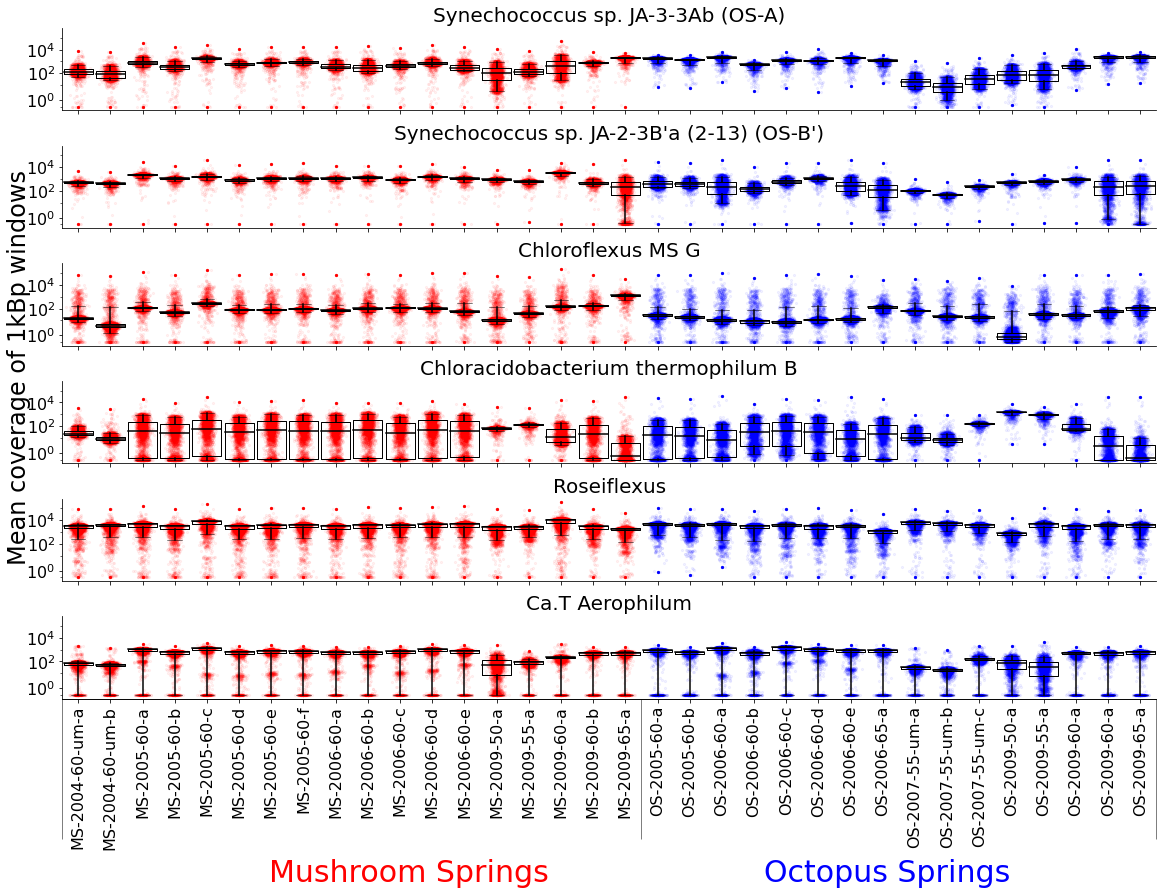

In [6]:
plt.rcParams.update(rcParams)
flierprops = dict(marker='x', markersize=0.5, linestyle='none')
boxprops = dict(linestyle='-', linewidth=1.0, color='black')

fig, ax = plt.subplots(6,1, figsize=(16,12), sharex = True, sharey = True)
i = 0
for g in genomes:
    if g == 'Synechococcus':
        continue
    
    boxes = list(Summary[g]["Reassembly.Summary.pkl"]['df_cov'][samples].T.values)
    positions = list(range(0, 34))
    for j in range(0, len(positions)):
        y = boxes[j]
        ax[i].boxplot(y, positions = [positions[j]], whis = [5,95], widths = [0.9], showfliers = False, 
                      boxprops = boxprops, flierprops = flierprops, whiskerprops = whiskerprops, 
                      capprops = capprops, medianprops = medianprops)
        x = np.random.normal(positions[j], 0.095, size=len(y))
        ax[i].scatter(x,y,color = spring_colors[j],alpha = 0.05, marker = 'o', s = 5, rasterized=True)
        ax[i].scatter([positions[j]]*2, [max(y), min(y)], color = spring_colors[j], marker = 'o', s = 5)
    ax[i].set_title(genome_labels[g], size = 20)
    i+=1
ax[5].set_yscale('symlog')
ax[5].set_yticks([1,100,10000])
ax[5].set_xticks(range(0, 34))
ax[5].set_xticklabels(x_ticks, rotation = 90)
sec2 = ax[5].secondary_xaxis(location=0)
sec2.set_xticks([-0.5, 17.5, 33.5], labels = ['','',''])
sec2.tick_params('x', length=140, width=0.5)
fig.text(0.22, -0.025, 'Mushroom Springs', color = 'red', size = 30)
fig.text(0.65, -0.025, 'Octopus Springs', color = 'blue', size = 30)

ax[5].set_xlim(-0.5, 33.5)

fig.text(-0.007, 0.57, 'Mean coverage of 1kBp windows', va='center', rotation='vertical', size = 24)
fig.tight_layout()

fig.savefig(plots_dir+'Fig-S2-Coverage.pdf',bbox_inches="tight")
fig.savefig(plots_dir+'Fig-S2-Coverage.png',bbox_inches="tight")

OSA
$50^oC$ 0
$55^oC$ 1
$60^oC$ 2
$60^oC$ 3
$65^oC$ 4
$50^oC$ 5
$55^oC$ 6
$60^oC$ 7
$60^oC$ 8
$65^oC$ 9
OSB
Chloroflexus_MS_G
Chloracidobacterium_thermophilum_B
Roseiflexus
Aerophilum


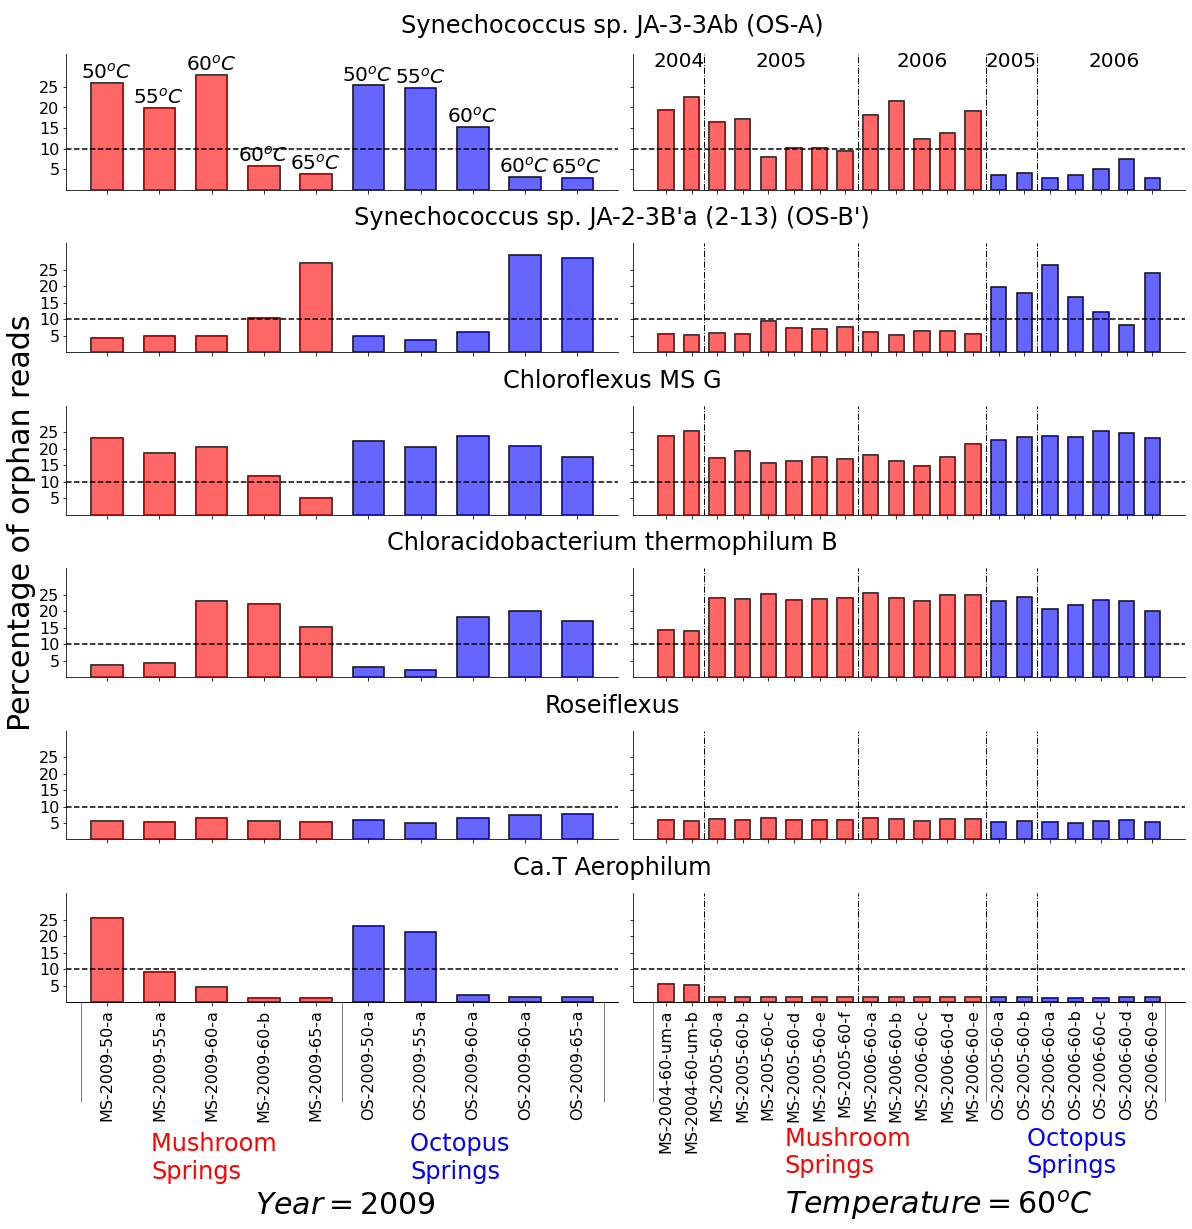

In [7]:
plt.rcParams.update(rcParams)
fig = plt.figure(constrained_layout = True,figsize = (16,16))
gs0 = fig.add_gridspec(12, 1, height_ratios = [1.5,5]+[1.5, 4]*4+[1.5,9])
ax_left = []
ax_right = []
ax_titles = []
for i in range(6):
    gs = gs0[i*2].subgridspec(1,1)    
    a = fig.add_subplot(gs[0])
    a.axis('off')
    ax_titles.append(a)
    gs = gs0[i*2+1].subgridspec(1,2)
    ax_left.append(fig.add_subplot(gs[0]))
    ax_right.append(fig.add_subplot(gs[1]))
ax = [ax_left, ax_right]

filter_temp = df_Metadata[df_Metadata['Year']==2009].sort_values(by = ['Spring','Avg_temperature'])
samples_temp = filter_temp['Sample_name'].tolist()
xticks_temp = []
for f in filter_temp['Table_1_name'].tolist():
    #f = f.replace("MS-","").replace("OS-","").replace("2009-","")
    xticks_temp.append(f)
colors_temp = ([mscolor]*len(filter_temp[filter_temp['Spring']=='Mushroom']) + 
               [oscolor]*len(filter_temp[filter_temp['Spring']=='Octopus']))

filter_year = df_Metadata[(df_Metadata['Year']<2009) & 
                          (df_Metadata['Avg_temperature'] == 60)].sort_values(by = ['Spring','Year','Avg_temperature'])
samples_year = filter_year['Sample_name'].tolist()
xticks_year = []
for f in filter_year['Table_1_name'].tolist():
    #f = f.replace("MS-","").replace("OS-","").replace("60-","")
    xticks_year.append(f)
ticks_sep = [-0.5]
years_sep = []
years = filter_year['Year'].tolist()
for i in range(1, len(years)-1):
    if years[i]!=years[i+1]:
        ticks_sep.append(i+0.5)
        years_sep.append(years[i])
years_sep.append(years[-1])

ticks_sep.append(len(years)+0.5)

colors_year = ([mscolor]*len(filter_year[filter_year['Spring']=='Mushroom']) + 
               [oscolor]*len(filter_year[filter_year['Spring']=='Octopus']))
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
i = 0
for g in genomes:
    if g == "Synechococcus": continue
    print(g)
    
    df = Summary[g]['Reassembly.Summary.pkl']['Summary']
    df = df.set_index('Sample')
    df['Frac_Orphaned'] = df['Orphaned Reads in Only One Genome ']/df['ReadCounts']*100.0
    
    df_temp = df.loc[samples_temp]
    bars = ax[0][i].bar(range(0,len(df_temp)), df_temp['Frac_Orphaned'], width = 0.6, color = 'black', fill=False, linewidth = 1.5)
    bars = ax[0][i].bar(range(0,len(df_temp)), df_temp['Frac_Orphaned'], width = 0.6, color = colors_temp, alpha = 0.6)
    
    ax_titles[i].text(0.5 * (left + right), 0.5 * (bottom + top), genome_labels[g],
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax_titles[i].transAxes, size = 24)
    
    #ax_titles[i].text(0.3,0.5,"\n"+genome_labels[g], size = 24)
    ax[0][i].axhline(10, linestyle = '--', color = 'black')
    ax[0][i].set_yticks([5,10,15,20,25], size = 24)
    ax[0][i].set_ylim([0,29])
    ax[0][i].set_xticklabels([])

    df_year = df.loc[samples_year]
    bars = ax[1][i].bar(range(0,len(df_year)), df_year['Frac_Orphaned'], width = 0.6, color = 'black', fill=False, linewidth = 1.5)
    bars = ax[1][i].bar(range(0,len(df_year)), df_year['Frac_Orphaned'], width = 0.6, color = colors_year, alpha = 0.6)
    ax[1][i].axhline(10, linestyle = '--', color = 'black')
    ax[1][i].set_yticks([5,10,15,20,25], size = 24)
    ax[1][i].set_ylim([0,33])
    ax[1][i].set_xticks(range(0, len(df_year)))
    ax[1][i].set_xticklabels([])
    ax[1][i].set_yticklabels([])
    for j in range(1,len(ticks_sep)):
        pos = (ticks_sep[j] + ticks_sep[j-1])/2
        if j != len(ticks_sep)-1:
            ax[1][i].axvline(ticks_sep[j], linewidth = 1, color = 'black', linestyle = '-.')
        if i==0:
            ax[1][i].annotate(str(int(years_sep[j-1])), (pos-1, 30), size = 20)
    Temps = [r'$50^oC$',r'$55^oC$',r'$60^oC$',r'$60^oC$',r'$65^oC$',
             r'$50^oC$',r'$55^oC$',r'$60^oC$',r'$60^oC$',r'$65^oC$']
    ax[0][i].set_xticks(range(0, len(df_temp)))
    ax[0][i].set_ylim([0,33])
    for j in range(0, len(df_temp)):
        if i ==0:
            pos = df_temp.iloc[j]['Frac_Orphaned']+1
            print(Temps[j], j)
            ax[0][i].annotate(Temps[j], (j-0.5, pos), size = 20)
    

    i+=1
ax[0][5].set_xticklabels(xticks_temp, rotation = 90)
ax[1][5].set_xticklabels(xticks_year, rotation = 90)

fig.text(-0.025, 0.55, 'Percentage of orphan reads', va='center', rotation='vertical', size = 30)

sec2 = ax[0][5].secondary_xaxis(location=0)
sec2.set_xticks([-0.5, 4.5, 9.5], labels = ['','',''])
sec2.tick_params('x', length=100, width=0.5)
fig.text(0.1, -0.02, 'Mushroom \nSprings', color = 'red', size = 24)
fig.text(0.325, -0.02, 'Octopus \nSprings', color = 'blue', size = 24)
fig.text(0.19, -0.05, r'$Year = 2009$', color = 'black', size = 30)


sec3 = ax[1][5].secondary_xaxis(location=0)
sec3.set_xticks([-0.5, 12.5, 19.5], labels = ['','',''])
sec3.tick_params('x', length=100, width=0.5)
fig.text(0.65, -0.015, 'Mushroom \nSprings', color = 'red', size = 24)
fig.text(0.86, -0.015, 'Octopus \nSprings', color = 'blue', size = 24)
fig.text(0.65, -0.05, r'$Temperature = 60^oC$', color = 'black', size = 30)

fig.savefig(plots_dir+'Fig-1-Orphaned_Reads.pdf',bbox_inches="tight")
fig.savefig(plots_dir+'Fig-1-Orphaned_Reads.png',bbox_inches="tight")

OSA 2932766
OSB 3046682
Chloroflexus_MS_G 4770266
Chloracidobacterium_thermophilum_B 3695372
Roseiflexus 5801598
Aerophilum 3425982


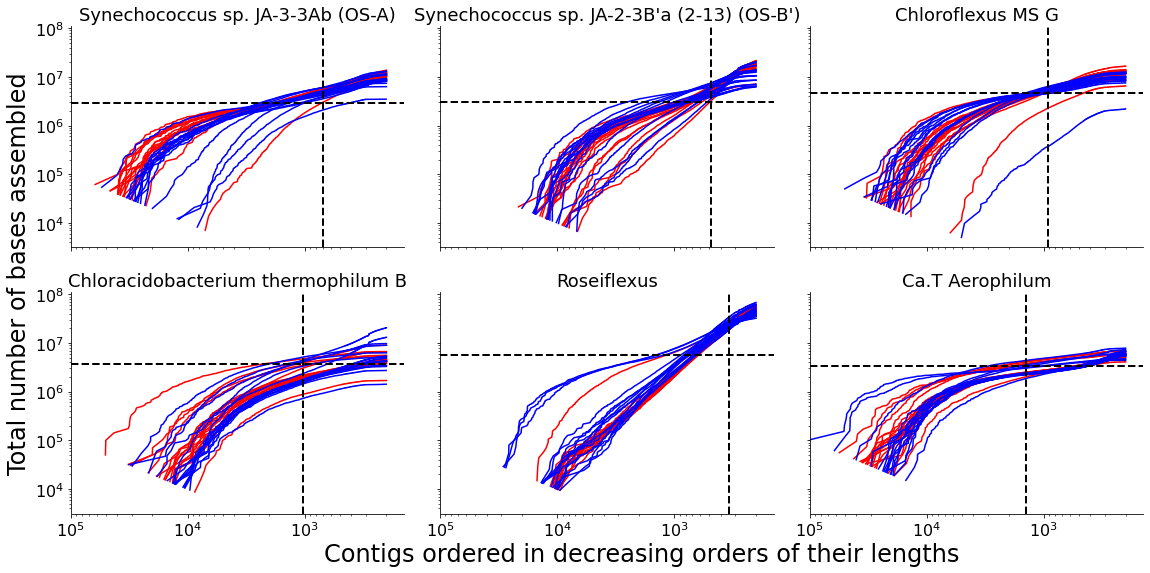

In [8]:
#sample_dict = dict(zip(df_Metadata['Sample_name'].tolist(), df_Metadata['Spring'].tolist()))
fig, ax = plt.subplots(2, 3, figsize = (16, 8), sharex = True, sharey = True)
k = 0
for g in genomes:
    if g == 'Synechococcus': continue
    i, j = int(k/3), int(k%3)
    avg_n50 = 0.0
    for p in range(0, len(samples)):
        ax[i][j].plot(Summary[g]['Reassembly.Summary.pkl']['Assembly'][samples[p]]['lengths'], 
                      Summary[g]['Reassembly.Summary.pkl']['Assembly'][samples[p]]['cumulative'], 
                      color = spring_colors[p], rasterized = True)
        avg_n50 += Summary[g]['Reassembly.Summary.pkl']['Assembly'][samples[p]]['NGx']
    ax[i][j].axhline(Summary[g]['Reassembly.Summary.pkl']['Assembly'][samples[p]]['Glen'], color = 'black', 
                     linestyle = '--', linewidth = 2)
    print(g, Summary[g]['Reassembly.Summary.pkl']['Assembly'][samples[p]]['Glen'])
    ax[i][j].axvline(avg_n50/len(samples), color = 'black', linestyle = '--', linewidth = 2)
    ax[i][j].set_title(genome_labels[g], size = 18)
    
    k += 1
ax[0][0].set_xlim(ax[0][0].get_xlim()[::-1])
ax[0][0].set_yscale('log')
ax[0][0].set_xscale('log')
ax[0][0].set_xlim([100000, 141])
fig.text(0.27, 0, 'Contigs ordered in decreasing orders of their lengths', size = 24)
fig.text(-0.005, 0.5, 'Total number of bases assembled', va='center', rotation='vertical', size = 24)

fig.tight_layout()
fig.savefig(plots_dir+'Fig-S1-Assembly.pdf',bbox_inches="tight")
fig.savefig(plots_dir+'Fig-S1-Assembly.png',bbox_inches="tight")

In [9]:
DatIN = load('/Users/harihara/Research-Activities/Data/Hot-Spring/species_sorted_filtered_sags.dat',allow_pickle=True)
Sample = []
Species = []
for f in DatIN.keys():
    values = DatIN[f]
    Sample += values
    
    if f == 'A':
        f = 'Synechococcus sp. JA-3-3Ab (OS-A)' 
    elif f == 'Bp':
        f = 'Synechococcus sp. JA-2-3B\'a (2-13) (OS-B\')'
    else:
        f = 'Ambiguous'
        
    Species += [f]*len(values)
df_singlecell_species = pd.DataFrame(data = {'Single_Cell_Sample':Sample, 'Species':Species})
df_singlecell_species['Single_Cell_Sample'] = df_singlecell_species['Single_Cell_Sample'].str.replace("_FD","")
df_single_summary = deepcopy(Summary['Synechococcus']['SAG.Summary.pkl']['Filtered_Alignments'])
df_single_summary = pd.merge(df_single_summary, df_singlecell_species, on = 'Single_Cell_Sample')
df_single_summary = df_single_summary.groupby(['Subject', 'Species']).count()[['Single_Cell_Sample']]\
.reset_index()\
.pivot_table(index = 'Subject', columns = 'Species', values = 'Single_Cell_Sample')
df_single_summary['Total'] = df_single_summary.sum(axis = 1)
df_single_summary = df_single_summary.sort_values(by = 'Total', ascending = False)
del df_single_summary['Total']
df_single_summary = df_single_summary.fillna(0)

OSA
OSB
Synechococcus
Chloroflexus_MS_G
Chloracidobacterium_thermophilum_B
Roseiflexus
Aerophilum


/Users/harihara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


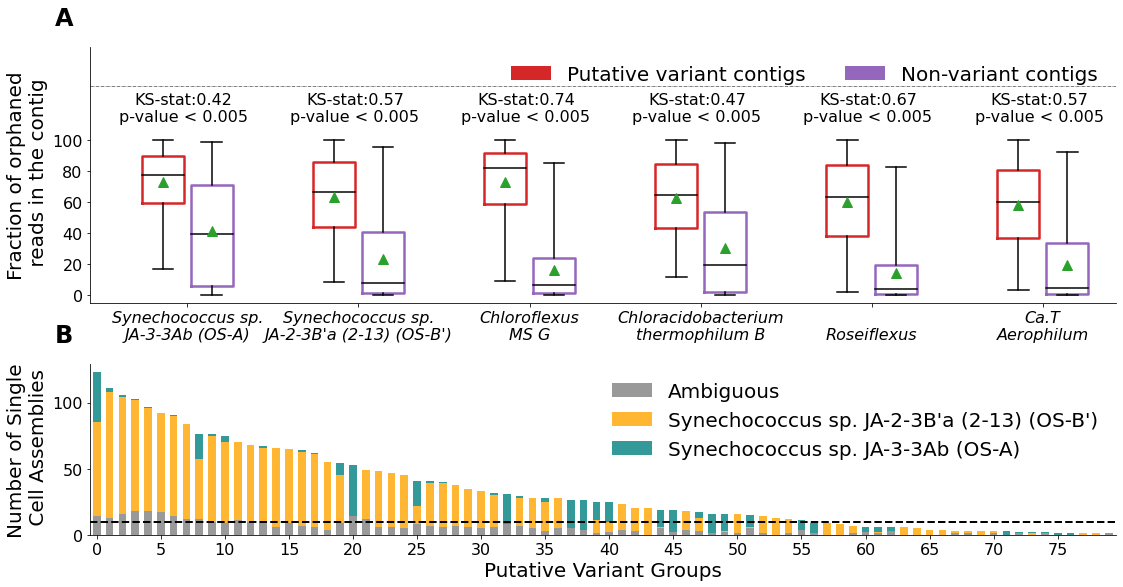

In [19]:
flierprops = dict(marker='x', markersize=2.5, linestyle='none', color = 'gray')
whiskerprops = dict(color='black',linewidth=1.5)
capprops = dict(color='black', linewidth=1.5)
medianprops = dict(linewidth=1.5, linestyle='-', color='black')
meanprops = dict(markersize = 10, color = 'black')

plt.rcParams.update(rcParams)

fig = plt.figure(constrained_layout = True,figsize = (16,8))
gs0 = fig.add_gridspec(2, 1,  height_ratios=[1.5,1])
gs1 = gs0[0].subgridspec(1, 1)
ax1 = fig.add_subplot(gs1[0])

gs2 = gs0[1].subgridspec(1, 1)
ax2 = fig.add_subplot(gs2[0])

gaps = 3.5
counter = 0

xticklabels = []
xticks = []
for g in genomes:
    print(g)
    if g == 'Synechococcus': continue
    label = ""
    splits = genome_labels[g].split(" ")
    label = " ".join(splits[0:int(len(splits)/2)])+"\n"+" ".join(splits[int(len(splits)/2):])
    xticklabels.append(label)
    df = Summary[g]['Orphaned_Reads.Summary.pkl']
    df = df[df['Read'] > 20]
    df_novel_filter = df.loc[df['Novel'] == 1]
    df_not_novel_filter = df.loc[df['Novel'] == -1]
    stat, p_val = ks_2samp(df_not_novel_filter['Or_Ratio'], df_novel_filter['Or_Ratio'])
    positions =  [counter, counter + 1]
    boxes = [df_novel_filter['Or_Ratio'], df_not_novel_filter['Or_Ratio']]
    c = ['C3', 'C4']
    
    for i in range(0, len(positions)):
        ax1.boxplot([boxes[i]], positions=[positions[i]], whis = [1.5,98.5], widths = [0.85],
                     showfliers = False, boxprops = dict(linestyle='-', linewidth=2.5, color=c[i]),
                     flierprops = flierprops, whiskerprops = whiskerprops, capprops = capprops, 
                     medianprops = medianprops, showmeans = True, meanprops = meanprops)
    
    if p_val <= 0.005: ptext = r'p-value < 0.005'
    else: ptext = r'p-value > 0.005'
    ax1.text(counter+0.85/2, 112, r'KS-stat:'+str(round(stat, 2))+'\n'+ptext, ha = 'center', 
             size = 16)
    xticks.append(counter+0.5)
    counter += gaps
    
ax1.bar(-10,0,color = 'C3', label = 'Putative variant contigs')
ax1.bar(-10,0,color = 'C4', label = 'Non-variant contigs')
ax1.legend(ncol = 2, loc = 1, frameon = False)    
ax1.set_xticks(xticks)    
ax1.set_xticklabels(xticklabels, rotation = 0, fontstyle = 'italic')    
ax1.set_ylim([-5, 160])
ax1.axhline(135, color = 'black', linewidth = 0.5, linestyle = '-.')
ax1.set_yticks(range(0, 110, 20))
ax1.set_ylabel('Fraction of orphaned\n reads in the contig')
ax1.set_xlim([-1.5, counter-1.5])

df_single_summary.reset_index().plot(kind = 'bar', stacked = True, ax = ax2, alpha = 0.8, width = 0.6, 
                                     color = ['gray','orange','teal'])
ax2.axhline(10, linewidth = 2, color = 'black', linestyle = '--')
ax2.set_ylabel('Number of Single\n Cell Assemblies')
ax2.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75])
ax2.set_xticklabels([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75], rotation = 0)
ax2.set_xlabel('Putative Variant Groups')
ax2.legend(frameon = False)

fig.text(0.06,1,"A", weight = "bold", size = 24)
fig.text(0.06,0.45,"B", weight = "bold", size = 24)
fig.tight_layout()

fig.savefig(plots_dir+'Fig-2-Orphaned_Reads_Statistical_Analysis.pdf',bbox_inches="tight")
fig.savefig(plots_dir+'Fig-2-Orphaned_Reads_Statistical_Analysis.png',bbox_inches="tight")

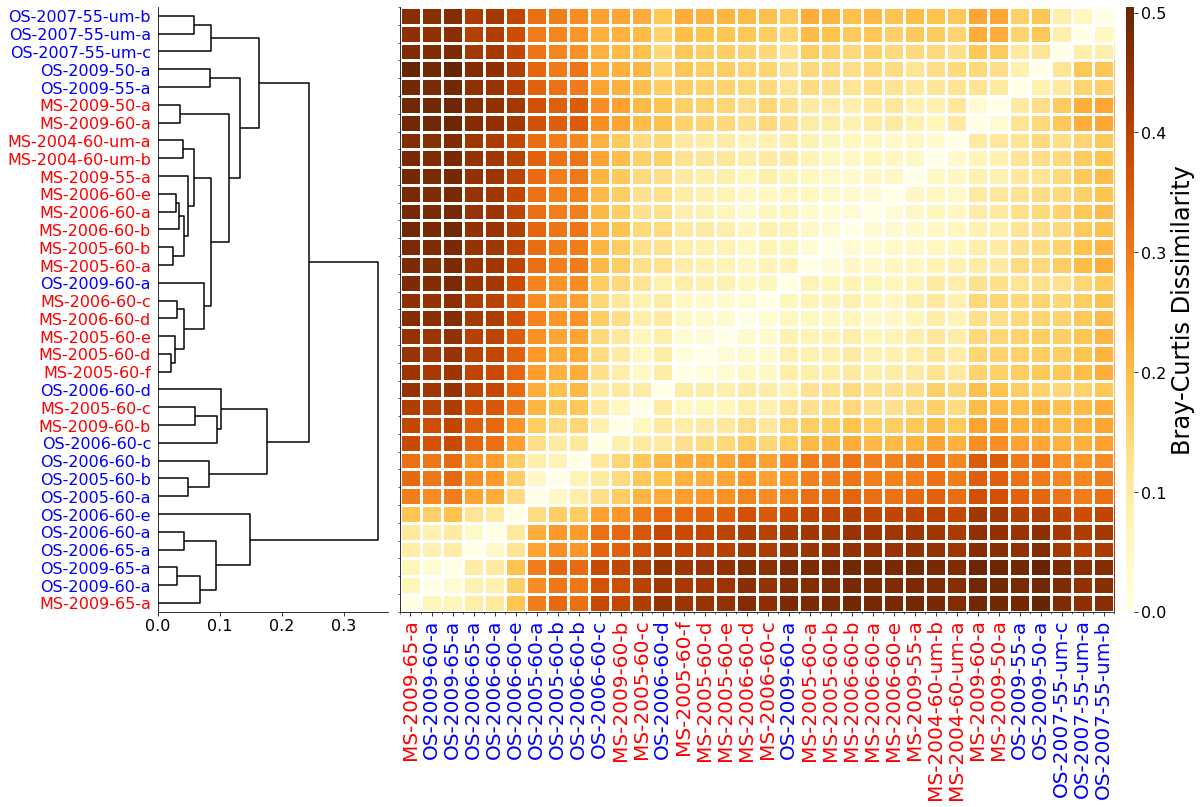

In [11]:
D = dict(zip(df_Metadata['Sample_name'].tolist(),df_Metadata['Table_1_name'].tolist()))

Dist_Mat = Summary['Synechococcus']['Respresentative_Abundances.Summary.pkl']['DistMat']
Feature_Mat = Summary['Synechococcus']['Respresentative_Abundances.Summary.pkl']['FeatMat']
ticks = np.array(Summary['Synechococcus']['Respresentative_Abundances.Summary.pkl']['Index'])

fig = plt.figure(figsize=(16,12))
axdendro = fig.add_axes([0.1,0.25,0.2,0.7])
axmatrix = fig.add_axes([0.31,0.25,0.62,0.7])
axcolor = fig.add_axes([0.94,0.25,0.0075,0.7])

Y = sch.linkage(squareform(Dist_Mat), method='weighted', optimal_ordering=1)
tree_index = sch.dendrogram(Y, color_threshold = 0, orientation='right', ax = axdendro, above_threshold_color='black')['leaves']
Dist_Mat = np.round(Dist_Mat[tree_index,:][:,tree_index], 5)

im = axmatrix.imshow(Dist_Mat, cmap  = "YlOrBr", aspect='auto', origin='lower', alpha = 1.0)
x_ticklabels = []
for t in ticks[tree_index]:
    x_ticklabels.append(D[t])
axdendro.set_yticklabels(x_ticklabels, size = 16)
a = [axdendro.get_yticklabels()[i].set_color(mscolor) if (sample_spring[ticks[tree_index][i]] == 'Mushroom' ) 
     else axdendro.get_yticklabels()[i].set_color(oscolor) for i in range(len(axdendro.get_yticklabels()))]

axmatrix.set_xticks(range(0, len(ticks)))
axmatrix.set_xticklabels(x_ticklabels, rotation = 90, size = 20)
a = [axmatrix.get_xticklabels()[i].set_color(mscolor)  if (sample_spring[ticks[tree_index][i]] == 'Mushroom' ) 
     else axmatrix.get_xticklabels()[i].set_color(oscolor) for i in range(len(axmatrix.get_xticklabels()))]

axmatrix.set_xticks(np.arange(-.5, 34, 1), minor=True)
axmatrix.set_yticks(np.arange(-.5, 34, 1), minor=True)
axmatrix.grid(which='minor', color='white', linestyle='-', linewidth=3)
axmatrix.set_yticks([])
cb = fig.colorbar(im, cax=axcolor)
cb.outline.set_visible(False)
axcolor.set_ylabel(r'Bray-Curtis Dissimilarity', size = 24)

fig.savefig(plots_dir+'Fig-3A-Synechococcus_Variant_Clustering.pdf',bbox_inches="tight")
fig.savefig(plots_dir+'Fig-3A-Synechococcus_Variant_Clustering.png',bbox_inches="tight")

Synechococcus [ 7. 17.] 	 [0.0109 0.0002]
Chloroflexus_MS_G [17.  5.] 	 [0.0002 0.0357]
Chloracidobacterium_thermophilum_B [0. 0.] 	 [0.6169 0.7263]
Roseiflexus [15.  4.] 	 [0.0005 0.0426]
Aerophilum [0. 2.] 	 [0.6495 0.1435]


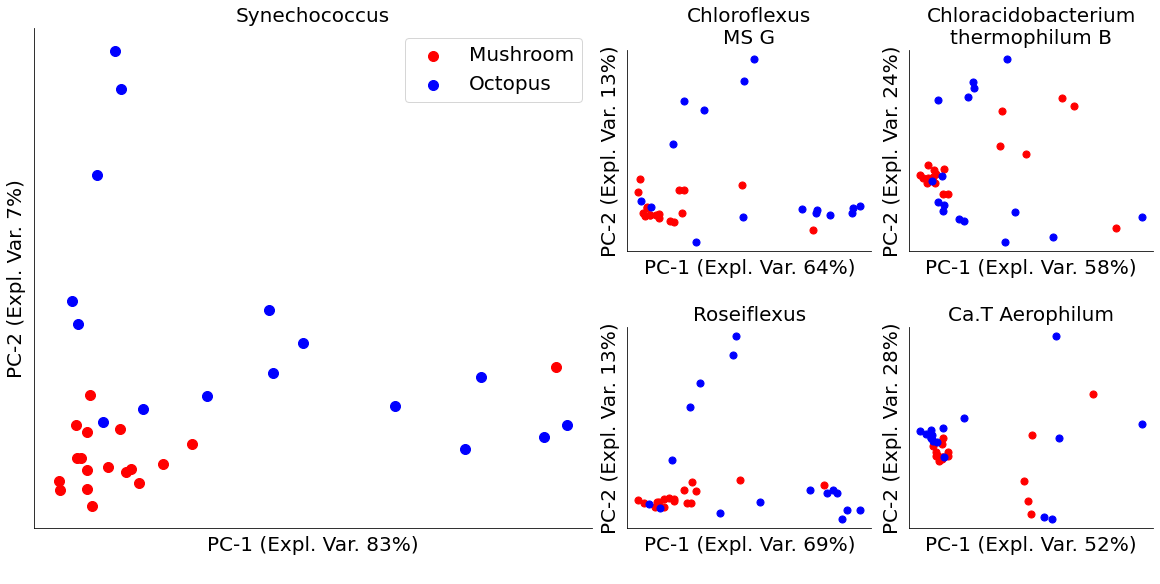

In [12]:
plt.rcParams.update(rcParams)

fig = plt.figure(constrained_layout = True,figsize = (16,8))
gs0 = fig.add_gridspec(1, 2)
ax = [fig.add_subplot(gs0[0])]
gs1 = gs0[1].subgridspec(2, 2)
for i in range(4): ax.append(fig.add_subplot(gs1[i]))

i = 0
titles = []
for g in genomes[2:]:
    label = genome_labels[g]
    splits = genome_labels[g].split(" ")
    if len(splits) > 2:
        label = " ".join(splits[0:int(len(splits)/2)])+"\n"+" ".join(splits[int(len(splits)/2):])
    titles.append(label)
    var = Summary[g]['Respresentative_Abundances.Summary.pkl']['Expl_Var']
    df = Summary[g]['Respresentative_Abundances.Summary.pkl']['PC_Transformed']
    df = df.join(df_Metadata[['Sample_name','Spring']].set_index('Sample_name'))
    df = df.reset_index().set_index('Spring')
    if g == 'Synechococcus': 
        df.loc['Mushroom'].plot.scatter('PC-1','PC-2', color = mscolor, ax = ax[i], s = 100, label = 'Mushroom')
        df.loc['Octopus'].plot.scatter('PC-1','PC-2', color = oscolor, ax = ax[i], s = 100, label = 'Octopus')
    df.loc['Mushroom'].plot.scatter('PC-1','PC-2', color = mscolor, ax = ax[i], s = 50)
    df.loc['Octopus'].plot.scatter('PC-1','PC-2', color = oscolor, ax = ax[i], s = 50)
   
    ax[i].set_xlabel('PC-1 (Expl. Var. '+str(round(var[0]*100))+'%)\n')
    ax[i].set_ylabel('PC-2 (Expl. Var. '+str(round(var[1]*100))+'%)')
    ax[i].set_title(titles[i], size = 20)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    i += 1
    
    f, p = f_oneway(df.loc['Octopus'][['PC-1','PC-2']], df.loc['Mushroom'][['PC-1','PC-2']], axis = 0)
    print(g, np.round(f), "\t", np.round(p, 4))
fig.savefig(plots_dir+'Fig-3B-Variants_PCA.pdf',bbox_inches="tight")
fig.savefig(plots_dir+'Fig-3B-Variants_PCA.png',bbox_inches="tight")

In [14]:
ored, mred, osred, msred = 0, 0, 0, 0
for s in Summary['Synechococcus']['SAG.Summary.pkl']['All_Alignments']['Single_Cell_Sample'].unique():
    if "Oc" in s: osred += 1
    if "ORed" in s: ored += 1
    if "Mu" in s: mred += 1
    if "MRed" in s: msred += 1
    
print("Oc", osred, "ORed", ored)
print("Mu", msred, "MRed", mred)

Oc 125 ORed 61
Mu 86 MRed 106


In [20]:
eggnog_path = '/Users/harihara/Mount/Hotsprings_Variant_Structure_Data_Analysis/Synechococcus/Filtered.Eggnog.Annotations.xlsx'
df_eggnog = pd.read_excel(eggnog_path)

OSError: [Errno 5] Input/output error: '/Users/harihara/Mount/Hotsprings_Variant_Structure_Data_Analysis/Synechococcus/Filtered.Eggnog.Annotations.xlsx'

In [ ]:
bp_counts = 0
a_counts = 0
poor_quality = 0
for h in T['Single_Cell_Sample'].tolist():
    if h+"_FD" in DatIN['Bp']:
        bp_counts += 1
    elif h+"_FD" in DatIN['A']:
        a_counts += 1
    elif h+"_FD" in DatIN['filtered']:
        poor_quality += 1
print(bp_counts)
print(a_counts)
print(poor_quality)

In [ ]:
df = Summary['OSA']['Reassembly.Summary.pkl']['Summary']
df['Frac_Orphaned'] = df['Orphaned Reads in Only One Genome ']/df['ReadCounts']*100.0
T = pd.merge(df, df_Metadata, left_on = ['Sample'], right_on = ['Sample_name'])
T.groupby(['Spring']).mean()[['Frac_Orphaned']]

In [ ]:
OSA = T[T['Table_1_name'].isin(['MS-2009-50-a','MS-2009-55-a','MS-2009-60-a','MS-2009-60-b','MS-2009-65-a',
                                'OS-2009-50-a','OS-2009-55-a','OS-2009-60-a','OS-2009-60-b','OS-2009-65-a'])]
np.corrcoef(OSA['Avg_temperature'],OSA['Frac_Orphaned'])

In [ ]:
df = Summary['OSB']['Reassembly.Summary.pkl']['Summary']
df['Frac_Orphaned'] = df['Orphaned Reads in Only One Genome ']/df['ReadCounts']*100.0
T = pd.merge(df, df_Metadata, left_on = ['Sample'], right_on = ['Sample_name'])
T.groupby(['Spring']).mean()[['Frac_Orphaned']]

In [ ]:
OSB = T[T['Table_1_name'].isin(['MS-2009-50-a','MS-2009-55-a','MS-2009-60-a','MS-2009-60-b','MS-2009-65-a',
                                'OS-2009-50-a','OS-2009-55-a','OS-2009-60-a','OS-2009-60-b','OS-2009-65-a'])]

In [ ]:
np.corrcoef(OSB['Avg_temperature'],OSB['Frac_Orphaned'])

In [ ]:
df = Summary['Aerophilum']['Reassembly.Summary.pkl']['Summary']
df['Frac_Orphaned'] = df['Orphaned Reads in Only One Genome ']/df['ReadCounts']*100.0
T = pd.merge(df, df_Metadata, left_on = ['Sample'], right_on = ['Sample_name'])
T.groupby(['Spring']).mean()[['Frac_Orphaned']]

In [ ]:
aero = T[T['Table_1_name'].isin(['MS-2009-50-a','MS-2009-55-a','MS-2009-60-a','MS-2009-60-b','MS-2009-65-a',
                                'OS-2009-50-a','OS-2009-55-a','OS-2009-60-a','OS-2009-60-b','OS-2009-65-a'])]
np.corrcoef(aero['Avg_temperature'],aero['Frac_Orphaned'])

In [21]:
len(df_singlecell_species)

378